# Day 2: Autocorrelation and Partial Autocorrelation
## Week 3: Time Series Analysis for Finance

---

**Learning Objectives:**
- Understand ACF and PACF
- Use correlograms to identify model orders
- Detect serial dependence in financial data
- Apply Ljung-Box test for white noise

In [1]:
# Day 2 Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')

# Load data
df = pd.read_csv('../datasets/raw_data/combined_adjusted_close.csv', 
                 index_col='Date', parse_dates=True)
prices = df[['AAPL', 'MSFT', 'SPY', 'JPM']].dropna()
returns = prices.pct_change().dropna()
log_returns = np.log(prices / prices.shift(1)).dropna()

print("=" * 60)
print("AUTOCORRELATION AND PACF - DAY 2")
print("=" * 60)

AUTOCORRELATION AND PACF - DAY 2


## 1. Autocorrelation Function (ACF)

**ACF(k)** measures correlation between Xₜ and Xₜ₋ₖ:

$$\rho_k = \frac{Cov(X_t, X_{t-k})}{Var(X_t)} = \frac{\gamma_k}{\gamma_0}$$

- Captures total correlation (direct + indirect)
- Range: [-1, 1]

AUTOCORRELATION FUNCTION (ACF)

ACF comparison (first 5 lags):
Lag    Manual       Statsmodels 
------------------------------
0      1.000000     1.000000    
1      -0.152254    -0.152254   
2      0.100590     0.100590    
3      -0.044484    -0.044484   
4      -0.068558    -0.068558   
5      0.051257     0.051257    


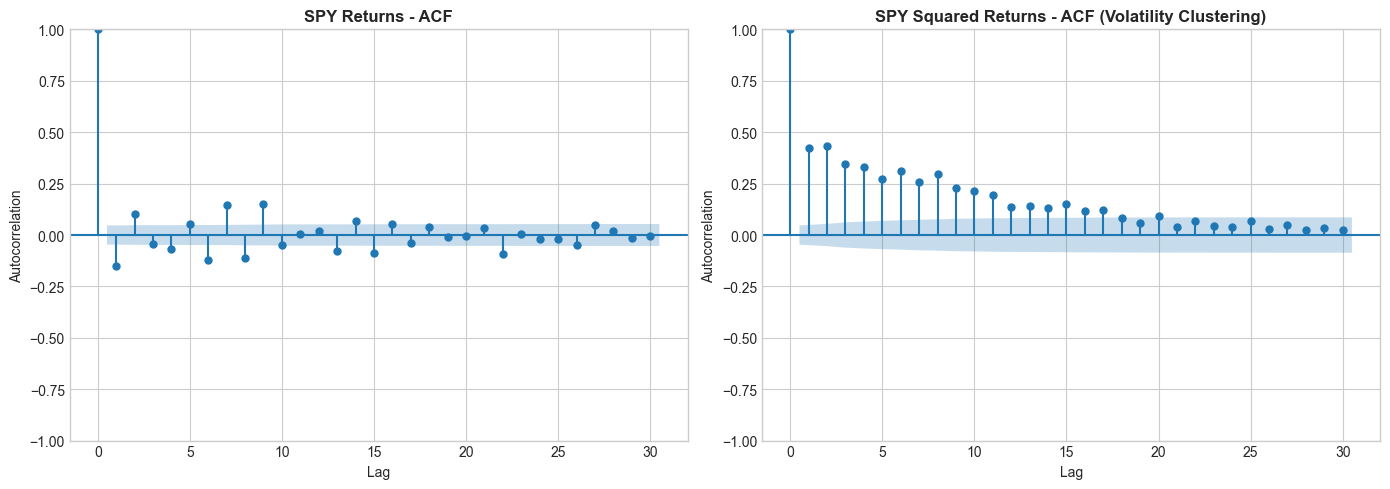


💡 Notice: Returns show weak ACF, but squared returns show strong ACF!
   This is volatility clustering - GARCH motivation.


In [2]:
# Calculate and visualize ACF
print("=" * 60)
print("AUTOCORRELATION FUNCTION (ACF)")
print("=" * 60)

spy_returns = returns['SPY']

# Calculate ACF manually for understanding
def manual_acf(series, lags):
    """Calculate ACF manually."""
    n = len(series)
    mean = series.mean()
    var = ((series - mean) ** 2).sum() / n
    
    acf_values = []
    for k in range(lags + 1):
        if k == 0:
            acf_values.append(1.0)
        else:
            cov = ((series[k:].values - mean) * (series[:-k].values - mean)).sum() / n
            acf_values.append(cov / var)
    return np.array(acf_values)

# Compare manual vs statsmodels
lags = 20
acf_manual = manual_acf(spy_returns, lags)
acf_stats = acf(spy_returns, nlags=lags, fft=True)

print(f"\nACF comparison (first 5 lags):")
print(f"{'Lag':<6} {'Manual':<12} {'Statsmodels':<12}")
print("-" * 30)
for i in range(6):
    print(f"{i:<6} {acf_manual[i]:<12.6f} {acf_stats[i]:<12.6f}")

# Plot ACF
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

plot_acf(spy_returns, lags=30, ax=axes[0], alpha=0.05)
axes[0].set_title('SPY Returns - ACF', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Lag')
axes[0].set_ylabel('Autocorrelation')

# ACF of squared returns (volatility clustering)
plot_acf(spy_returns ** 2, lags=30, ax=axes[1], alpha=0.05)
axes[1].set_title('SPY Squared Returns - ACF (Volatility Clustering)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Lag')
axes[1].set_ylabel('Autocorrelation')

plt.tight_layout()
plt.show()

print("\n💡 Notice: Returns show weak ACF, but squared returns show strong ACF!")
print("   This is volatility clustering - GARCH motivation.")

## 2. Partial Autocorrelation Function (PACF)

**PACF(k)** measures direct correlation between Xₜ and Xₜ₋ₖ, controlling for intermediate lags.

- PACF(1) = ACF(1) always
- PACF removes indirect effects
- Key for identifying AR order

PARTIAL AUTOCORRELATION FUNCTION (PACF)

ACF vs PACF Comparison:
Lag    ACF          PACF        
------------------------------
0      1.000000     1.000000    
1      -0.152254    -0.152254   
2      0.100590     0.079246    
3      -0.044484    -0.018870   
4      -0.068558    -0.087913   
5      0.051257     0.036435    
6      -0.121192    -0.099850   
7      0.146295     0.108028    
8      -0.111167    -0.065790   
9      0.150906     0.112809    
10     -0.046692    -0.011085   


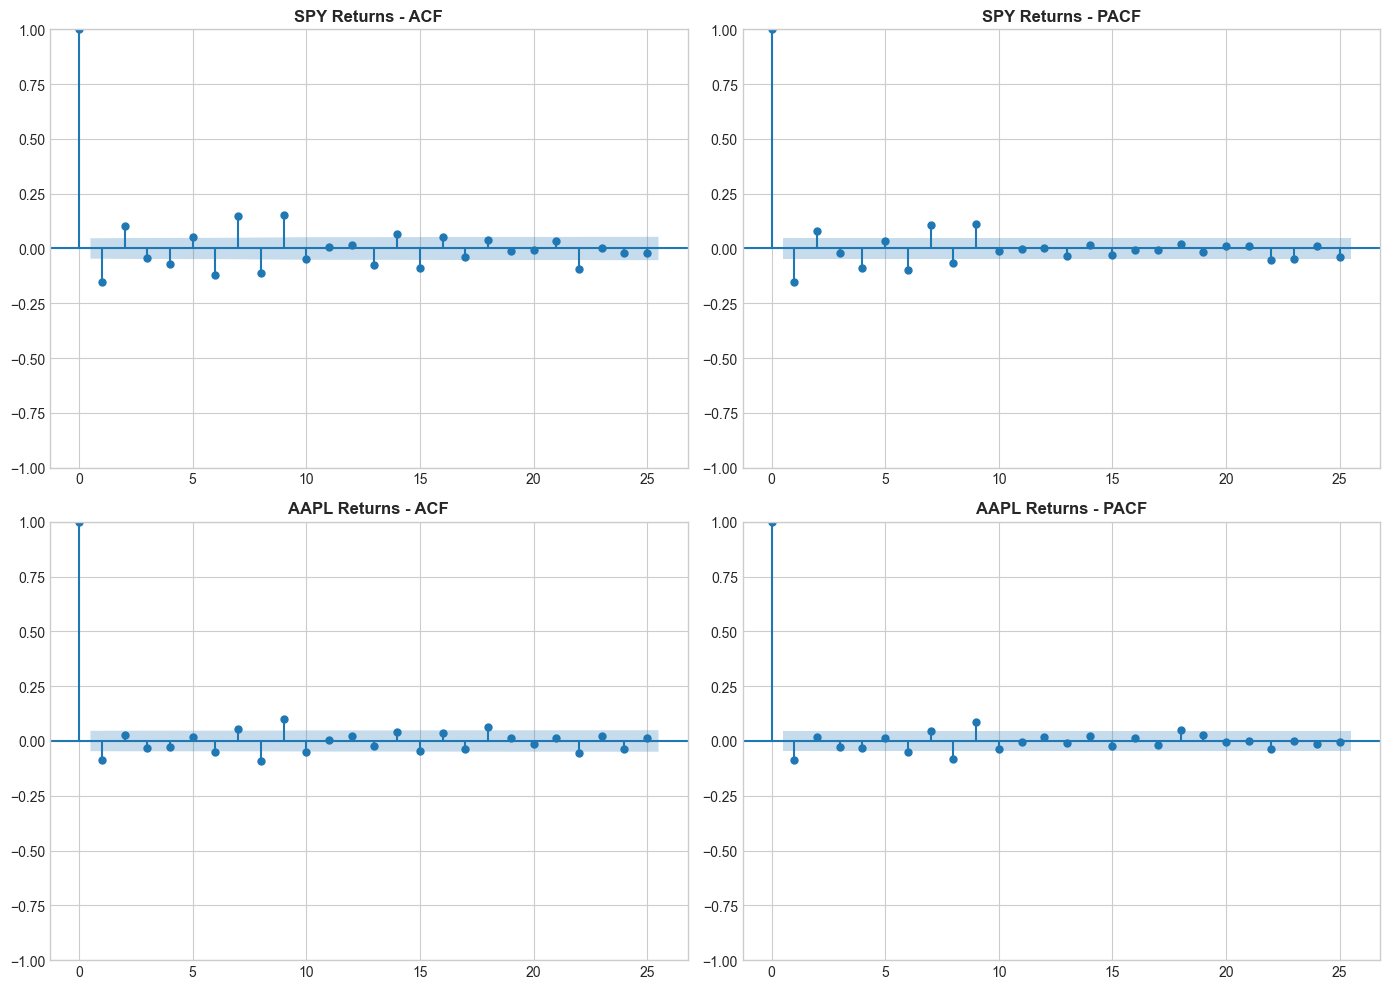

In [3]:
# PACF Analysis
print("=" * 60)
print("PARTIAL AUTOCORRELATION FUNCTION (PACF)")
print("=" * 60)

# Calculate PACF
pacf_values = pacf(spy_returns, nlags=20, method='ywm')
acf_values = acf(spy_returns, nlags=20)

print("\nACF vs PACF Comparison:")
print(f"{'Lag':<6} {'ACF':<12} {'PACF':<12}")
print("-" * 30)
for i in range(11):
    print(f"{i:<6} {acf_values[i]:<12.6f} {pacf_values[i]:<12.6f}")

# Visual comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# SPY returns
plot_acf(spy_returns, lags=25, ax=axes[0,0], alpha=0.05)
axes[0,0].set_title('SPY Returns - ACF', fontweight='bold')

plot_pacf(spy_returns, lags=25, ax=axes[0,1], alpha=0.05, method='ywm')
axes[0,1].set_title('SPY Returns - PACF', fontweight='bold')

# AAPL returns
plot_acf(returns['AAPL'], lags=25, ax=axes[1,0], alpha=0.05)
axes[1,0].set_title('AAPL Returns - ACF', fontweight='bold')

plot_pacf(returns['AAPL'], lags=25, ax=axes[1,1], alpha=0.05, method='ywm')
axes[1,1].set_title('AAPL Returns - PACF', fontweight='bold')

plt.tight_layout()
plt.show()

## 3. Using ACF/PACF for Model Selection

| Model | ACF Pattern | PACF Pattern |
|-------|-------------|--------------|
| AR(p) | Exponential decay | Cuts off after lag p |
| MA(q) | Cuts off after lag q | Exponential decay |
| ARMA(p,q) | Tails off | Tails off |

ACF/PACF PATTERNS FOR MODEL IDENTIFICATION


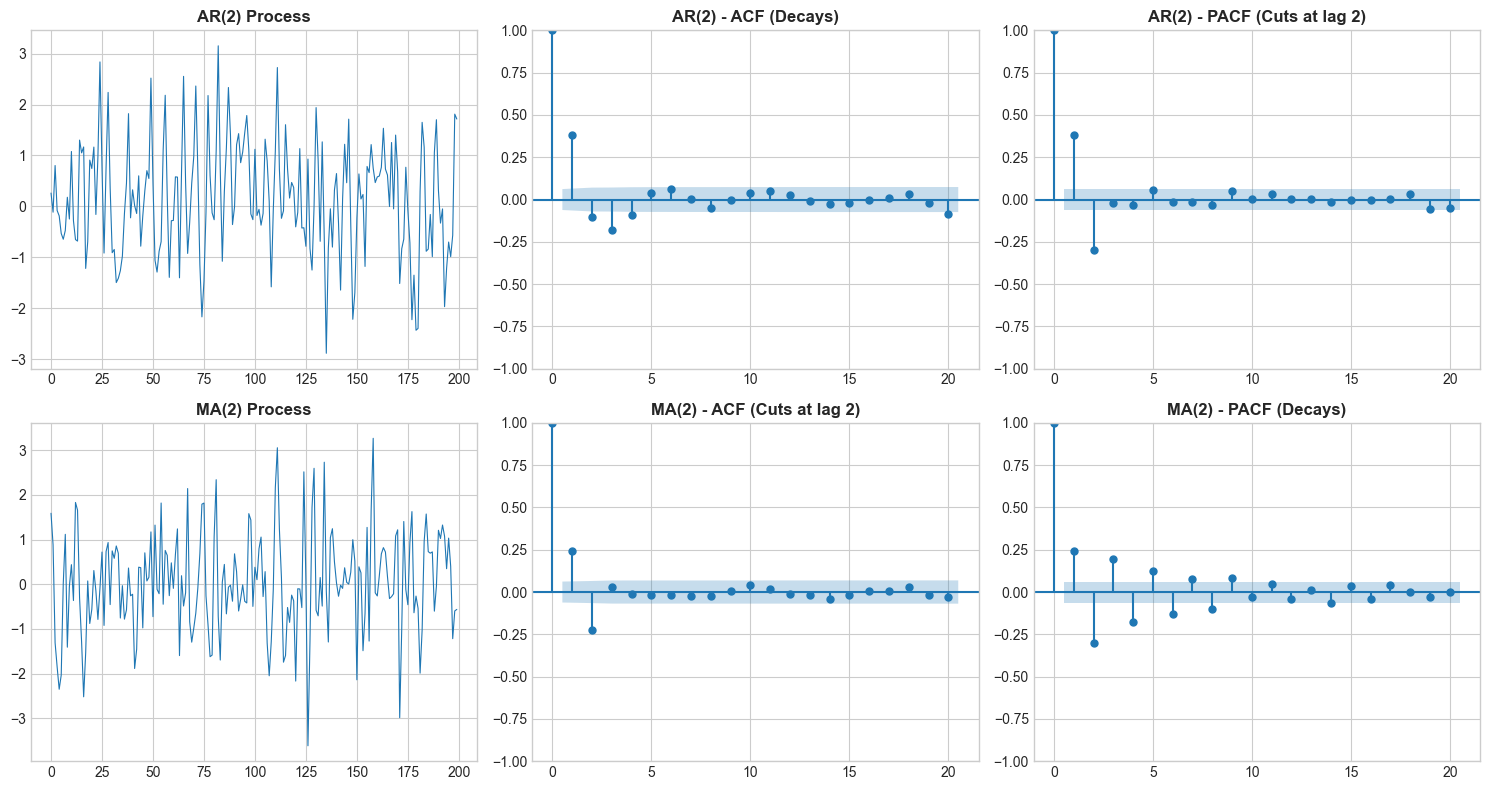


📊 Pattern Summary:
   AR(p): ACF decays, PACF cuts off after p
   MA(q): ACF cuts off after q, PACF decays


In [4]:
# Simulate processes to demonstrate patterns
print("=" * 60)
print("ACF/PACF PATTERNS FOR MODEL IDENTIFICATION")
print("=" * 60)

np.random.seed(42)
n = 1000

# Simulate AR(2) process
ar2 = np.zeros(n)
for t in range(2, n):
    ar2[t] = 0.5 * ar2[t-1] - 0.3 * ar2[t-2] + np.random.normal(0, 1)

# Simulate MA(2) process
eps = np.random.normal(0, 1, n+2)
ma2 = eps[2:] + 0.5 * eps[1:-1] - 0.3 * eps[:-2]

fig, axes = plt.subplots(2, 3, figsize=(15, 8))

# AR(2)
axes[0,0].plot(ar2[-200:], lw=0.8)
axes[0,0].set_title('AR(2) Process', fontweight='bold')

plot_acf(ar2, lags=20, ax=axes[0,1], alpha=0.05)
axes[0,1].set_title('AR(2) - ACF (Decays)', fontweight='bold')

plot_pacf(ar2, lags=20, ax=axes[0,2], alpha=0.05, method='ywm')
axes[0,2].set_title('AR(2) - PACF (Cuts at lag 2)', fontweight='bold')

# MA(2)
axes[1,0].plot(ma2[-200:], lw=0.8)
axes[1,0].set_title('MA(2) Process', fontweight='bold')

plot_acf(ma2, lags=20, ax=axes[1,1], alpha=0.05)
axes[1,1].set_title('MA(2) - ACF (Cuts at lag 2)', fontweight='bold')

plot_pacf(ma2, lags=20, ax=axes[1,2], alpha=0.05, method='ywm')
axes[1,2].set_title('MA(2) - PACF (Decays)', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n📊 Pattern Summary:")
print("   AR(p): ACF decays, PACF cuts off after p")
print("   MA(q): ACF cuts off after q, PACF decays")

## 4. Ljung-Box Test for White Noise

Tests whether autocorrelations are jointly zero:
- H₀: Data is white noise (no autocorrelation)
- H₁: Significant autocorrelation exists

In [5]:
# Ljung-Box Test
print("=" * 60)
print("LJUNG-BOX TEST FOR WHITE NOISE")
print("=" * 60)

def ljung_box_test(series, lags=[10, 20, 30], name='Series'):
    """Perform Ljung-Box test at multiple lags."""
    print(f"\n{name}:")
    print("-" * 40)
    
    lb_results = acorr_ljungbox(series.dropna(), lags=lags, return_df=True)
    
    for lag in lags:
        stat = lb_results.loc[lag, 'lb_stat']
        pval = lb_results.loc[lag, 'lb_pvalue']
        conclusion = 'White noise ✓' if pval > 0.05 else 'Serial correlation ✗'
        print(f"  Lag {lag:2d}: Q-stat={stat:8.2f}, p={pval:.4f} → {conclusion}")
    
    return lb_results

# Test various series
ljung_box_test(returns['SPY'], name='SPY Returns')
ljung_box_test(returns['SPY'] ** 2, name='SPY Squared Returns')
ljung_box_test(np.abs(returns['SPY']), name='SPY Absolute Returns')

print("\n💡 Key Finding:")
print("   Returns may look like white noise,")
print("   but squared/absolute returns show strong serial correlation!")
print("   → This motivates GARCH models for volatility.")

LJUNG-BOX TEST FOR WHITE NOISE

SPY Returns:
----------------------------------------
  Lag 10: Q-stat=  206.21, p=0.0000 → Serial correlation ✗
  Lag 20: Q-stat=  250.37, p=0.0000 → Serial correlation ✗
  Lag 30: Q-stat=  278.79, p=0.0000 → Serial correlation ✗

SPY Squared Returns:
----------------------------------------
  Lag 10: Q-stat= 1822.46, p=0.0000 → Serial correlation ✗
  Lag 20: Q-stat= 2115.33, p=0.0000 → Serial correlation ✗
  Lag 30: Q-stat= 2150.75, p=0.0000 → Serial correlation ✗

SPY Absolute Returns:
----------------------------------------
  Lag 10: Q-stat= 2066.66, p=0.0000 → Serial correlation ✗
  Lag 20: Q-stat= 2783.86, p=0.0000 → Serial correlation ✗
  Lag 30: Q-stat= 3058.57, p=0.0000 → Serial correlation ✗

💡 Key Finding:
   Returns may look like white noise,
   but squared/absolute returns show strong serial correlation!
   → This motivates GARCH models for volatility.


ACF/PACF SUMMARY FOR ALL ASSETS


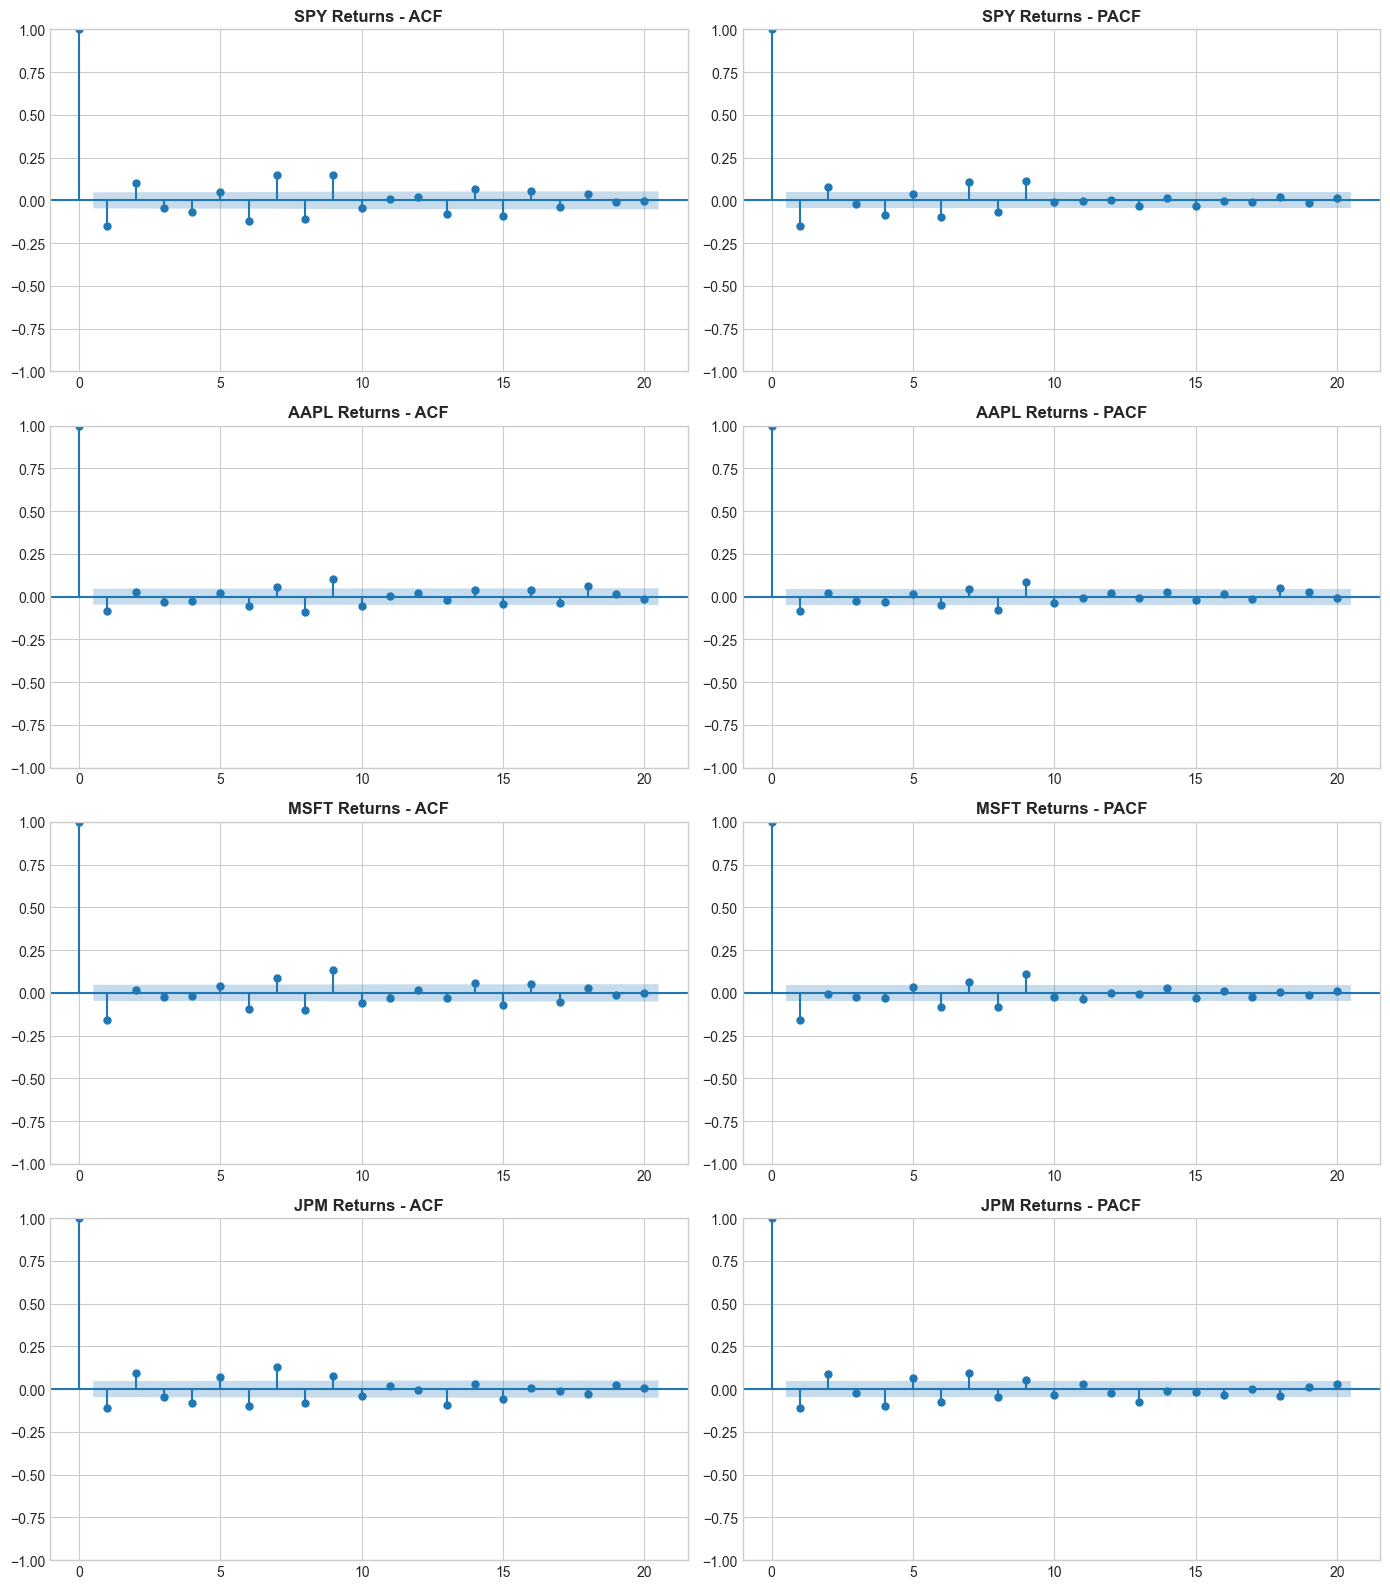

In [6]:
# Summary: ACF/PACF for all assets
print("=" * 60)
print("ACF/PACF SUMMARY FOR ALL ASSETS")
print("=" * 60)

fig, axes = plt.subplots(4, 2, figsize=(14, 16))

assets = ['SPY', 'AAPL', 'MSFT', 'JPM']

for i, asset in enumerate(assets):
    plot_acf(returns[asset], lags=20, ax=axes[i,0], alpha=0.05)
    axes[i,0].set_title(f'{asset} Returns - ACF', fontweight='bold')
    
    plot_pacf(returns[asset], lags=20, ax=axes[i,1], alpha=0.05, method='ywm')
    axes[i,1].set_title(f'{asset} Returns - PACF', fontweight='bold')

plt.tight_layout()
plt.show()

## 📝 Key Takeaways - Day 2

### ACF vs PACF:
| Measure | What it shows | Use for |
|---------|---------------|--------|
| ACF | Total correlation at lag k | MA order identification |
| PACF | Direct correlation at lag k | AR order identification |

### Model Selection Rules:
- ACF cuts off → MA(q) where q is cutoff lag
- PACF cuts off → AR(p) where p is cutoff lag
- Both tail off → ARMA needed

### Financial Data Patterns:
- Returns: weak or no ACF/PACF
- Squared returns: strong ACF (volatility clustering)
- Absolute returns: strong ACF (volatility clustering)

### Interview Questions:
- "What's the difference between ACF and PACF?"
- "How do you use ACF/PACF to identify ARMA orders?"
- "Why do squared returns show autocorrelation when returns don't?"